# <center>实验8 聚类分析</center>

<B>1. 基本概念</B>

K-means算法是一种基于距离的聚类算法。

采用距离作为相似性的评价指标，即认为两个对象的距离越近，其相似度就越大。

该算法认为类簇是由距离靠近的对象组成的，因此把得到紧凑且独立的簇作为最终目标.

<B>2. 核心思想</B>

通过迭代寻找$K$个簇的一种划分方案，使得用这$K$个簇的均值来代表相应各类样本时所得的总体误差最小。

$K$个簇具有以下特点:各簇本身尽可能的紧凑，而各簇之间尽可能的分开。

K-means算法的基础是最小误差平方和准则，其目标函数是:

<center> $SSE= \sum_{i=1}^{k} \sum_{x \in C_i} dist(c_i,x)^2$ </center>

各簇内的样本越相似，其与该类均值间的误差平方越小，对所有类所得到的误差平方求和，即可验证分为$K$类时，各簇是否是最优的。

<B>3. 质心初始化</B>

K-means++通过一种更合理的方式来选择初始聚类中心，使得算法更有可能找到全局最优解，而不是陷入局部最优。

在K-means++中，对于每一个未被选作聚类中心的点 $x$，计算其到最近的聚类中心的距离 $D$($x$)，通常是欧氏距离。

选择下一个聚类中心的概率与距离平方成正比：

<center> $P(x)= \frac{D(x)^2}{\sum_{x \in X}D(x)^2}$ </center>

分母是指对数据集$X$中的所有点$x$的距离平方$D(x)^2$求和
                        
这意味着，如果一个点$x$到最近的聚类中心的距离较大，那么它被选为下一个聚类中心的概率也较高。


<B>4. 数据集</B>

本实验采用二维数据集，共80个样本，部分数据如下：
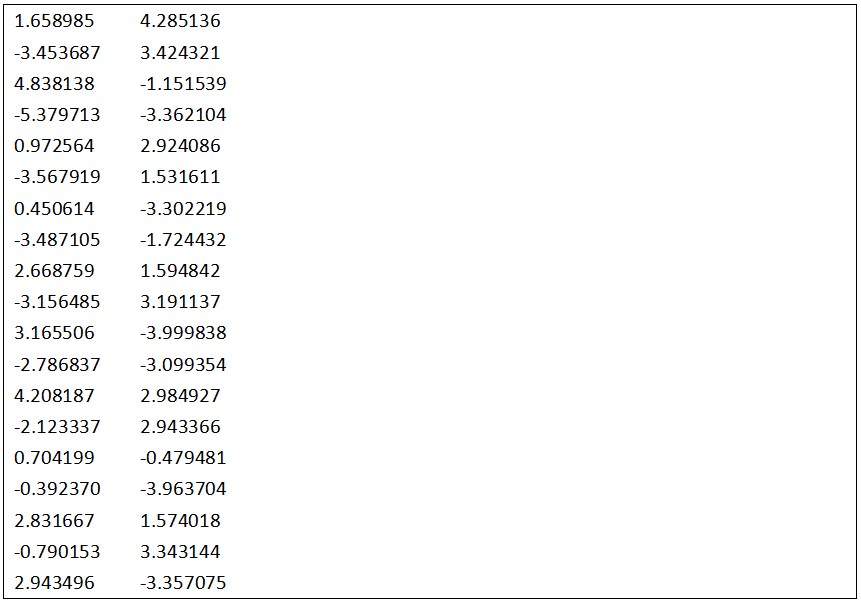

In [12]:
import numpy as np
from numpy import *

In [13]:
# 加载并输出数据
def loadDataSet(fileName):
    data = np.loadtxt(fileName, delimiter='\t')
    return data
data = loadDataSet('dataSet.txt')
x = data[:,0]
y = data[:,1]

print(data[:10])  #输出前10个

[[ 1.658985  4.285136]
 [-3.453687  3.424321]
 [ 4.838138 -1.151539]
 [-5.379713 -3.362104]
 [ 0.972564  2.924086]
 [-3.567919  1.531611]
 [ 0.450614 -3.302219]
 [-3.487105 -1.724432]
 [ 2.668759  1.594842]
 [-3.156485  3.191137]]


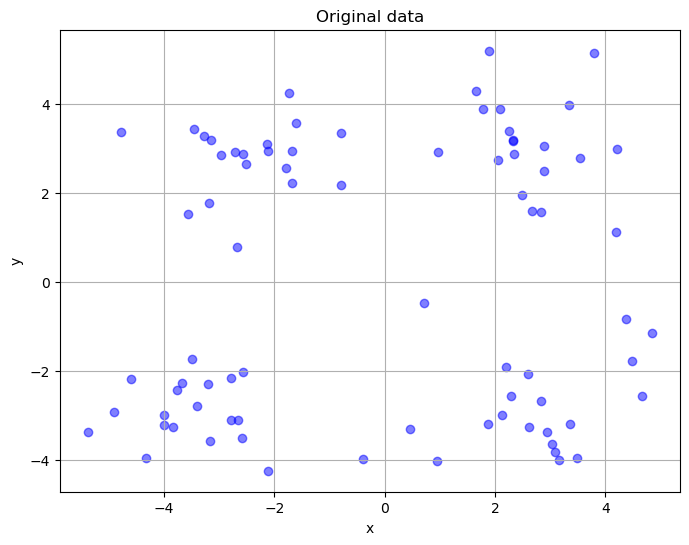

In [14]:
# 对数据进行可视化
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.title('Original data')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x,y,alpha=0.5,c='blue', label='Data Points')
plt.grid(True)

In [15]:
# 计算欧氏距离
def distEclid(vecA, vecB):
    return sqrt(sum(power(vecA - vecB, 2)))    #计算两个对象之间的距离

In [16]:
#1. 随机选取k个质心，返回的数组中保存有初始质心的坐标
def randCent(dataSet, k):
    n = np.shape(dataSet)[1]
    centroids = np.zeros((k, n))  # 总共k个质心，每个质心有n个坐标值
 
    #补充你的代码

    return centroids

#输出4个随机初始质心
centroids = randCent(data, 4) 
print("Initial random centroids:\n", centroids)  

Initial random centroids:
 [[ 2.50738483 -0.91791105]
 [ 2.39133756 -2.86185385]
 [-2.21208367  4.93281971]
 [-1.83880661  4.33458969]]


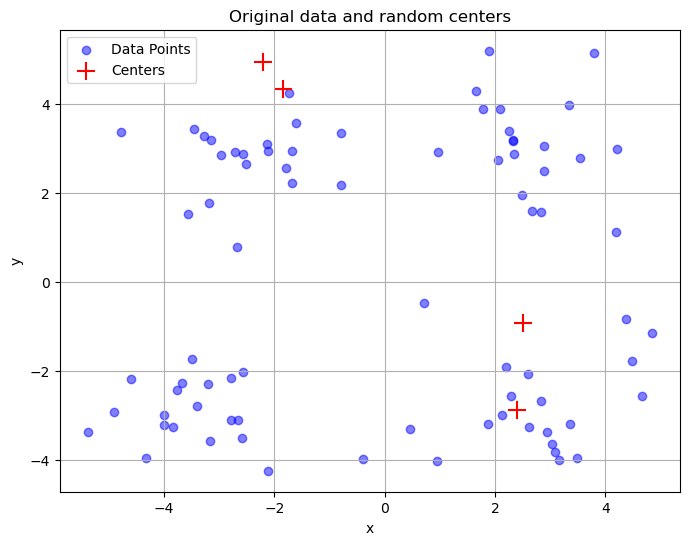

In [17]:
# 对随机初始质心进行可视化
plt.figure(figsize=(8, 6))
plt.title('Original data and random centers')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x,y,alpha=0.5,c='blue', label='Data Points')
plt.scatter(centroids[:,0], centroids[:,1], color='r',s=150,marker='+',label='Centers')
plt.legend()
plt.grid(True)

In [18]:
# 使用𝐾-means++初始化质心
def initialize_centers(X, k, seed=50):
    if seed is not None:
        np.random.seed(seed)  # 设置随机种子，保证随机性一致
    
    centers = [X[np.random.randint(X.shape[0])]]  # 随机选择第一个中心
    while len(centers) < k:
        # 计算到最近中心的平方距离
        dist_sq = np.array([min(np.linalg.norm(x - c)**2 for c in centers) for x in X])
        probs = dist_sq / dist_sq.sum()  # 计算概率
        cumulative_probs = probs.cumsum()
        r = np.random.rand()
        # 按累计概率选择下一个中心
        for j, p in enumerate(cumulative_probs):
            if r < p:
                centers.append(X[j])
                break
    return np.vstack(centers)

k = 4  # 设定中心点数量
createCent = initialize_centers(data, k)
print("Created centroids:\n", createCent) 


Created centroids:
 [[ 3.542056  2.778832]
 [-3.156485  3.191137]
 [ 0.450614 -3.302219]
 [-4.323818 -3.938116]]


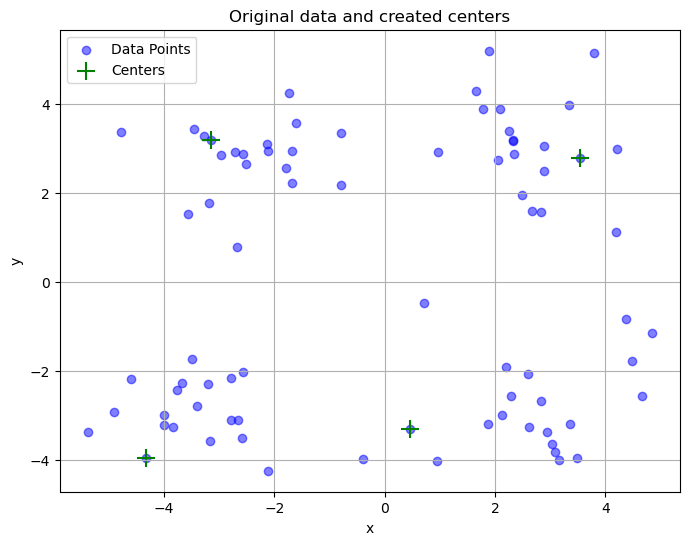

In [19]:
# 对创建的初始质心进行可视化
plt.figure(figsize=(8, 6))
plt.title('Original data and created centers')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x,y,alpha=0.5,c='blue', label='Data Points')
plt.scatter(createCent[:,0], createCent[:,1], color='g',s=150,marker='+',label='Centers')
plt.legend()
plt.grid(True)

In [21]:
#2. k-means 聚类算法
def kMeans(dataSet, k, distMeans=distEclid, createCent=randCent):
    m, n = dataSet.shape
    clusterAssment = np.zeros((m, 2))   # 用于存放该样本属于哪簇及到质心距离
    centroids = createCent(dataSet, k)  # 质心初始化

    #补充你的代码
    
    return centroids, clusterAssment

#输出聚类结果
centroids, clusterAssment = kMeans(data, 4, distEclid, initialize_centers) 
print("Final centroids:\n", centroids)  #最终的聚类中心
print("Cluster assignment:\n", clusterAssment)  #每个样本被分配的簇标号，以及到聚类中心的距离

Final centroids:
 [[ 2.6265303   3.10868015]
 [-2.46154315  2.78737555]
 [ 2.65077367 -2.79057124]
 [-3.53973889 -2.89384326]]
Cluster assignment:
 [[ 0.          2.32019227]
 [ 1.          1.39004893]
 [ 2.          7.4709894 ]
 [ 3.          3.60477283]
 [ 0.          2.76967952]
 [ 1.          2.80101213]
 [ 2.          5.10248599]
 [ 3.          1.37029303]
 [ 0.          2.29348921]
 [ 1.          0.64596748]
 [ 2.          1.72727548]
 [ 3.          0.60909593]
 [ 0.          2.51695276]
 [ 1.          0.13871642]
 [ 2.          9.13029102]
 [ 2.         10.63696385]
 [ 0.          2.39726898]
 [ 1.          3.1024236 ]
 [ 2.          0.40661288]
 [ 3.          0.49023594]
 [ 0.          0.13870636]
 [ 1.          0.510241  ]
 [ 2.          0.9946502 ]
 [ 3.          0.03195031]
 [ 0.          1.31601173]
 [ 1.          0.90820377]
 [ 2.          0.54533578]
 [ 3.          0.31668166]
 [ 0.          0.21378691]
 [ 1.          4.05632356]
 [ 2.          4.44868518]
 [ 3.          

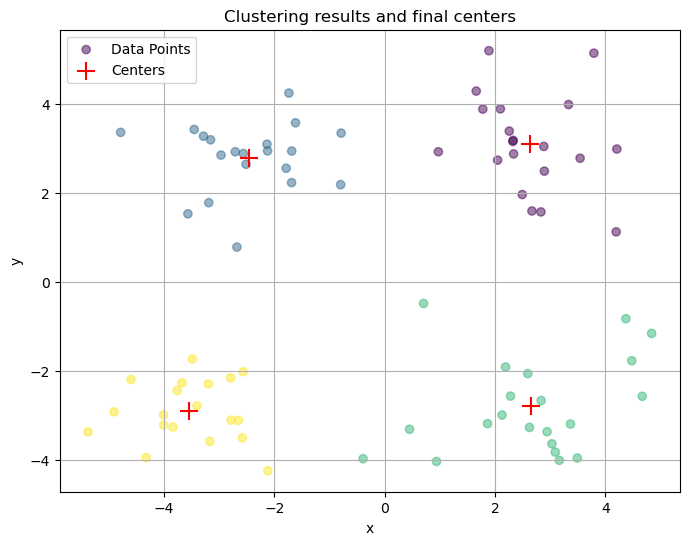

In [22]:
# 对聚类结果进行可视化
plt.figure(figsize=(8, 6))
plt.title('Clustering results and final centers')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x,y,alpha=0.5,c=clusterAssment[:,0], label='Data Points')
plt.scatter(centroids[:,0], centroids[:,1], color='r',s=150,marker='+',label='Centers')
plt.legend()
plt.grid(True)

In [23]:
# 计算轮廓系数指标
from sklearn.metrics import silhouette_score
score = silhouette_score(data, clusterAssment[:,0] , metric='euclidean')
score

0.6566268049712372